In [1]:
import numpyro
numpyro.set_host_device_count(4)
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

import warnings
warnings.filterwarnings('ignore', message='The RandomType SharedVariables')
warnings.filterwarnings('ignore', message='Skipping `CheckAndRaise` Op')

plt.rcParams.update({
    'figure.figsize': (14, 4),
    'figure.dpi': 144,
    'axes.grid': True,
    'grid.linewidth': 0.5,
    'grid.linestyle': '--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False,
    'figure.constrained_layout.use': True
})

import numpy as np
seed = sum(map(ord, 'Fun with VARS'))
rng = np.random.default_rng()

In [2]:
def plot_timeseries_posterior(idata, data=None, ax=None, color='tab:blue', data_color='k', label=None):
    if ax is None:
        fig, ax = plt.subplots()

    mu = idata.mean(dim=['chain', 'draw'])
    hdi = az.hdi(idata)
    key = list(hdi.data_vars.keys())[0]
    hdi = hdi[key]
    
    x_values = mu.coords['time'].values

    ax.plot(x_values, mu, color=color, label=label)
    ax.fill_between(x_values, *hdi.values.T, alpha=0.25, color=color, label=f'{label} HDI 94%' if label is not None else None)
    
    if data is not None:
        ax.plot(x_values, data, color=data_color, ls='--', label='Data')
    
    if label is not None:
        ax.legend()
    
    return ax

# Vector Autoregerssion

A second model class available in `statespace` is `BayesianVARMAX`. This is currently the only available multivariate time series available. 

A VAR is a system of equations in which the present value of each time series is a function of past observations of not only its own past observations, but those of all other time series as well. Here's a VAR(1) in three variables, $x_t, y_t, z_t$: 

$$
\begin{align}
x_t &= \gamma_{x,x} x_{t-1} + \gamma_{x,y} y_{t-1} + \gamma_{x,z} z_{t-1} + \varepsilon_{x, t} \\
y_t &= \gamma_{y,x} x_{t-1} + \gamma_{y,y} y_{t-1} + \gamma_{y,z} z_{t-1} + \varepsilon_{y, t} \\
z_t &= \gamma_{z,x} x_{t-1} + \gamma_{z,y} y_{t-1} + \gamma_{z,z} z_{t-1} + \varepsilon_{z, t} \\
\end{align}
$$

Clearly this is a linear system, so we can define $\alpha_t = \begin{bmatrix} x_t \\ y_t \\ z_t \end{bmatrix}$ and $\Gamma = \begin{bmatrix} \gamma_{x, x} & \gamma_{x,y} & \gamma_{x,z} \\ \gamma_{y, x} & \gamma_{y,y} & \gamma_{y,z} \\ \gamma_{z, x} & \gamma_{z,y} & \gamma_{z,z}\end{bmatrix}$ and we get our statespace form:

$$
\alpha_t = \Gamma \alpha_{t-1} + \varepsilon_t
$$

If we want more lags, though, this isn't sufficent, because we can't have $\alpha_{t-2}$ in the statespace equation. So the actual $T$ matrix is somewhat more complex. If you're interested in the details, see this notebook:

https://github.com/pymc-devs/pymc-experimental/blob/main/notebooks/VARMAX%20Example.ipynb

## Data

For data, I'll use some macroeconomic data that comes packaged with statsmodels. It has quarterly US GDP, private consumption, and private investment between 1959Q2 and 2009Q3.

To make life easier on the modeling, I'm doing some data preprocessing:

1. Taking logs transforms multiplicative errors to linear errors, which should make the time series covaraince stationary (hopefully)
2. Taking first differences removes a deterministic linear trend, which I'm not that interested in modeling (although we could!)
3. Normalizing the data so I don't have to think about priors on different data scales

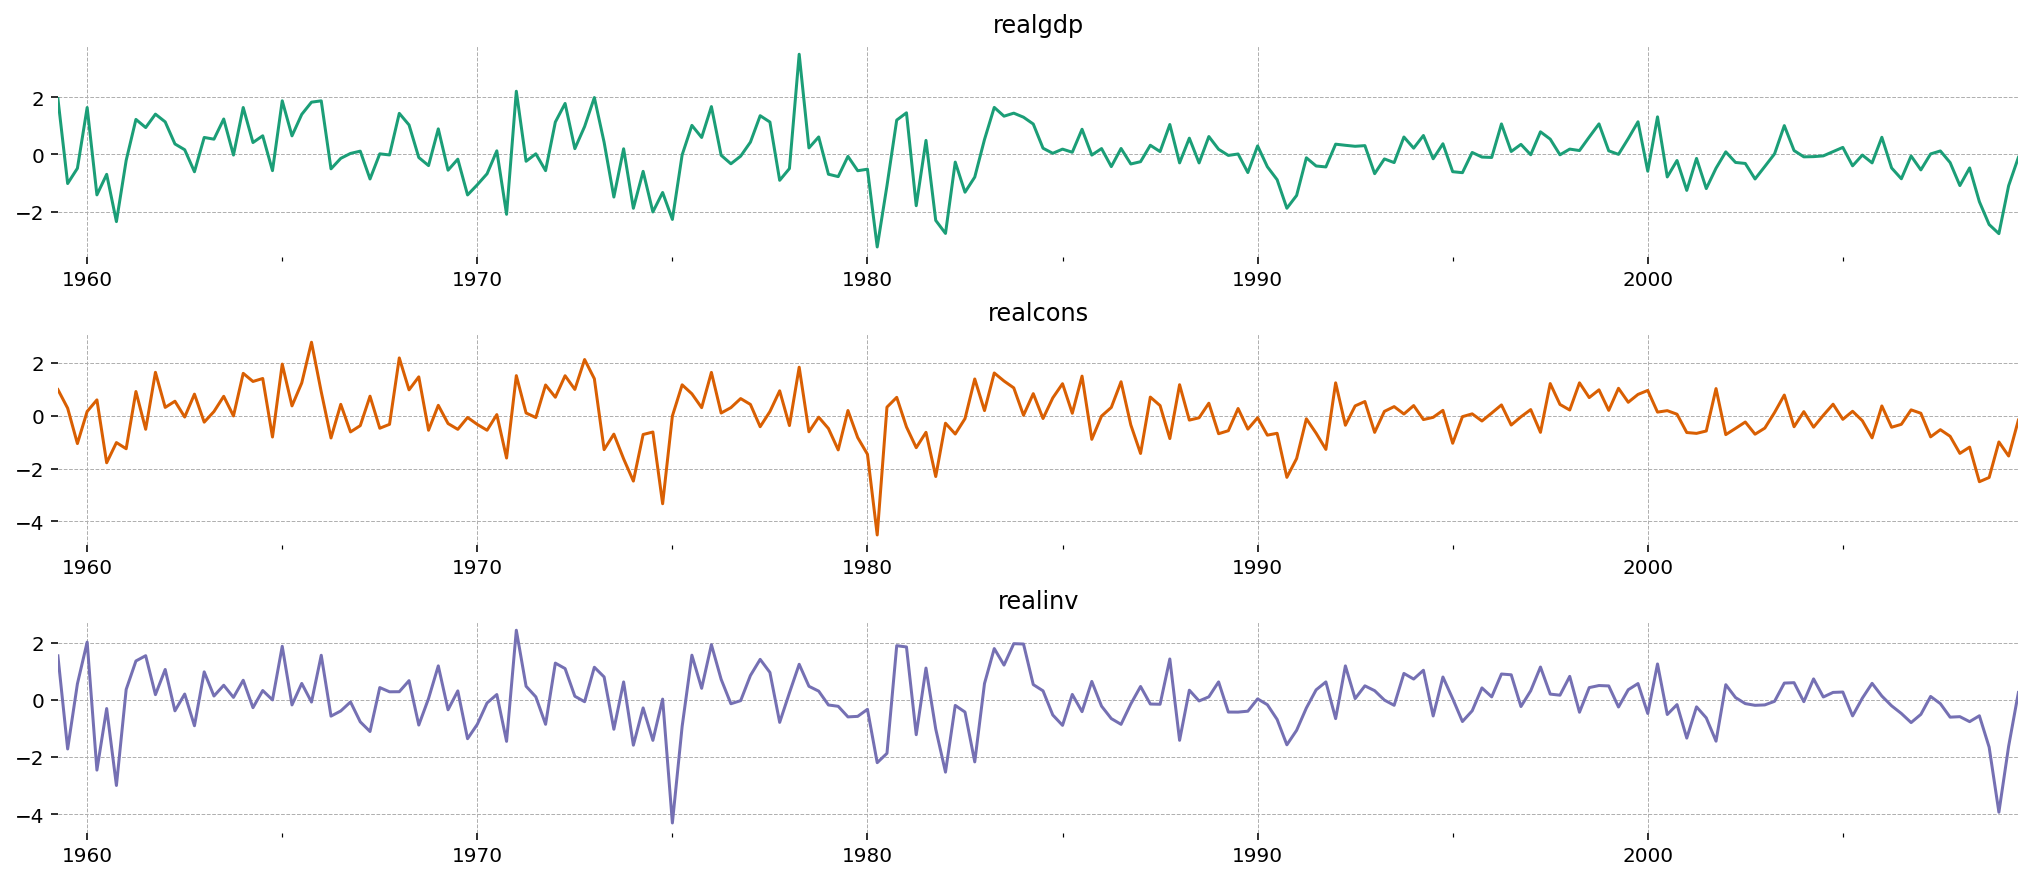

In [3]:
import statsmodels.api as sm
mdata = sm.datasets.macrodata.load_pandas().data
mdata.index = pd.DatetimeIndex(
    mdata[["year", "quarter"]].map(lambda x: str(int(x))).apply(lambda x: "Q".join(x), axis=1)
)
data = mdata[["realgdp", "realcons", "realinv"]].apply(np.log).diff().dropna()
data = (data - data.mean()) / data.std()
data.index.freq = data.index.inferred_freq

colors = plt.color_sequences['Dark2']

fig, ax = plt.subplots(3, 1, figsize=(14, 6))
for i, (axis, name) in enumerate(zip(fig.axes, data)):
    data[name].plot(ax=axis, title=name, legend=False, color=colors[i])

# VAR in `PyMCStateSpace`

To build a VAR, import the `BayesianVARMAX` class from `pymc_experimental.statespace` and provide the order.

Right away, you will notice that there are a lot of parameters in a VAR. The coefficient matrix alone will have $pk^2$ parameters, where $p$ is the number of lags, and $k$ is the number of time series. So it's probably a good idea to use some kind of shrinkage prior.

We are still allowed to promise that our priors will be stationary using the `stationary_initialization=True` argument, but this promise is *much* harder to keep than in the AR(1) case.

In [4]:
from pymc_experimental import statespace as pmss
ss_mod = pmss.BayesianVARMAX(order=(2, 0),
                             endog_names = data.columns,
                             stationary_initialization=True,
                             measurement_error=False)

The following parameters should be assigned priors inside a PyMC model block: 
	ar_params -- shape: (3, 2, 3), constraints: None, dims: ('observed_state', 'ar_lag', 'observed_state_aux')
	state_cov -- shape: (3, 3), constraints: Positive Semi-definite, dims: ('shock', 'shock_aux')


Let's look at what it means to keep the promise of stationary. The condition for a statespace model to be stationary is that the eigenvalues of the transition matrix $T$ are strictly inside the unit circle.

In [5]:
with pm.Model(coords=ss_mod.coords) as eig_model:
    ar_params = pm.Normal('ar_params', dims=['observed_state', 'ar_lag', 'observed_state_aux'])
    state_cov_diag = pm.Gamma('state_cov_diag', alpha=2, beta=1, dims=['shock'])
    state_cov = pm.Deterministic('state_cov', pt.diag(state_cov_diag), dims=['shock', 'shock_aux'])
    
    # Sample the prior first, otherwise you'll get linalg errors related to the stationary initialization failing
    prior = pm.sample_prior_predictive()    
    
    ss_mod.build_statespace_graph(data)


Sampling: [ar_params, state_cov_diag]


We can use a new method we haven't seen yet: `sample_statespace_matrices`. This takes an `idata` (posterior or prior), and a list of matrix names from `x0, P0, c, d, T, Z, R, H, Q`. It returns one matrix for each sample in the priovided `idata`.

In [6]:
prior_T = ss_mod.sample_statespace_matrices(prior.prior, matrix_names=['T'])

Sampling: []


Output()

Unfortunately, we can't use `pt.linalg.eigs` to directly compute the eigenvalues for us on the graph. Pytensor is very fussy about types, and will cast complex outputs to float, discarding the complex part. We need that! So instead we use `xarray.apply_unfunc` to broadcast `np.linalg.eigvals` across our prior $T$ samples

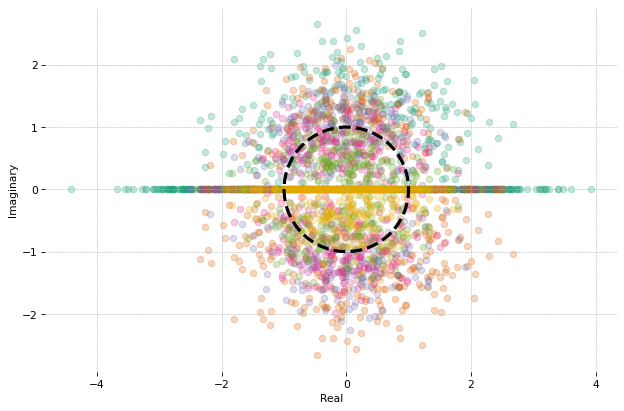

In [7]:
import xarray as xr

def plot_eigenvalues(idata):
    eigs = xr.apply_ufunc(np.linalg.eigvals,
                          idata,
                          input_core_dims=[['state', 'state_aux']],
                          output_core_dims=[['state']])
    eigs = eigs.stack(sample = ['chain', 'draw'])['T']
    
    fig, ax = plt.subplots(figsize=(8, 8), dpi=77, subplot_kw={'aspect':'equal'})

    # Plot a unit circle
    circle_grid = np.linspace(-np.pi, np.pi)
    ax.plot(np.cos(circle_grid), np.sin(circle_grid), c='k', ls='--', lw=3, zorder=100)
    colors = plt.color_sequences['Dark2']
    
    # Scatter the eigenvalues, real on the x-axis and imaginary on the y-axis
    for i, state in enumerate(eigs.coords['state'].values):
        real_part = eigs.sel(state=state).real
        imag_part = eigs.sel(state=state).imag
        ax.scatter(real_part, 
                   imag_part, 
                   alpha=0.25, 
                   color=colors[i])
        
        ax.set(xlabel='Real', ylabel='Imaginary')
    plt.show()
    
plot_eigenvalues(prior_T.posterior_predictive)

The Bayesian VAR literature has many specialized priors for trying to address this problem. 

One "easy" strategy is to just abandon the promise of stationarity. In this case, we will have to provide the model with initial values for $x_0$ and $P_0$. These priors are both important and unimportant. 

They are unimportant because if you have a long time series, they will not meaningfully influence forecasts from your model. Their influence will be washed away by the Kalman Filtering process about about 10-20 updates.

The are important beacuse the data will have very little information about these values. Whatever you put in for the prior is what you are going to get out.

In [8]:
ss_mod = pmss.BayesianVARMAX(order=(2, 0),
                             endog_names = data.columns,
                             stationary_initialization=False,
                             measurement_error=False)

The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (6,), constraints: None, dims: ('state',)
	P0 -- shape: (6, 6), constraints: Positive Semi-definite, dims: ('state', 'state_aux')
	ar_params -- shape: (3, 2, 3), constraints: None, dims: ('observed_state', 'ar_lag', 'observed_state_aux')
	state_cov -- shape: (3, 3), constraints: Positive Semi-definite, dims: ('shock', 'shock_aux')


In [9]:
with pm.Model(coords=ss_mod.coords) as var_model:
    
    # For x0, I choose something very close to 0, since that's the steady-state of the stationary model
    x0 = pm.Normal('x0', sigma=0.1, dims=['state'])
    
    # For P0, we find a Gamma prior with 95% of the mass between 0.5 and 2, which I took by looking at the data
    P0_diag = pm.Gamma('P0_diag', **pm.find_constrained_prior(pm.Gamma, 
                                                  lower=0.5, 
                                                  upper=2.0, 
                                                  init_guess={'alpha':2, 'beta':1}),
                      dims=['state'])
    
    P0 = pm.Deterministic('P0', pt.diag(P0_diag), dims=['state', 'state_aux'])
    ar_params = pm.Normal('ar_params', dims=['observed_state', 'ar_lag', 'observed_state_aux'])
    
    # Let's also upgrade the shock covariance to be dense, rather than diagonal
    state_chol, *_ = pm.LKJCholeskyCov('state_chol', n=3, eta=1, sd_dist=pm.Exponential.dist(1))
    state_cov = pm.Deterministic('state_cov', state_chol @ state_chol.T, dims=['shock', 'shock_aux'])
    
    ss_mod.build_statespace_graph(data, mode='JAX')
    prior = pm.sample_prior_predictive()
    idata = pm.sample(nuts_sampler='numpyro')

Sampling: [P0_diag, ar_params, obs, state_chol, x0]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling appears to have gone well. We have estimates for the lags and the shock covariance matrix. We'll figure out if they make sense by looking at several post-estimation outputs.

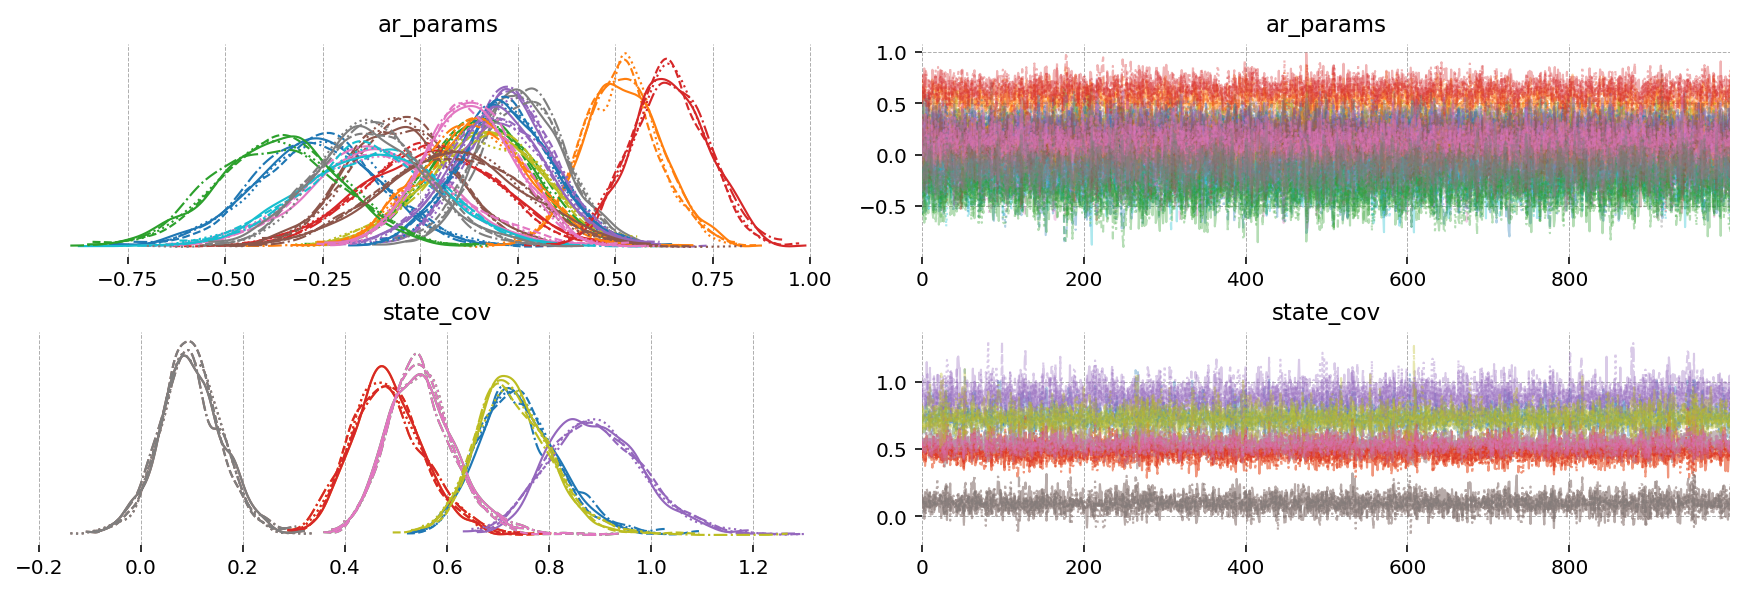

In [10]:
az.plot_trace(idata, var_names=['ar_params', 'state_cov']);

A first check, though, is to look at the stationarity situation in our posterior samples. As you can see, the posterior is strictly stationary. This is what we expect from the data, since we detrended it. So there's a lot to be gained by using smarter priors here.

Sampling: []


Output()

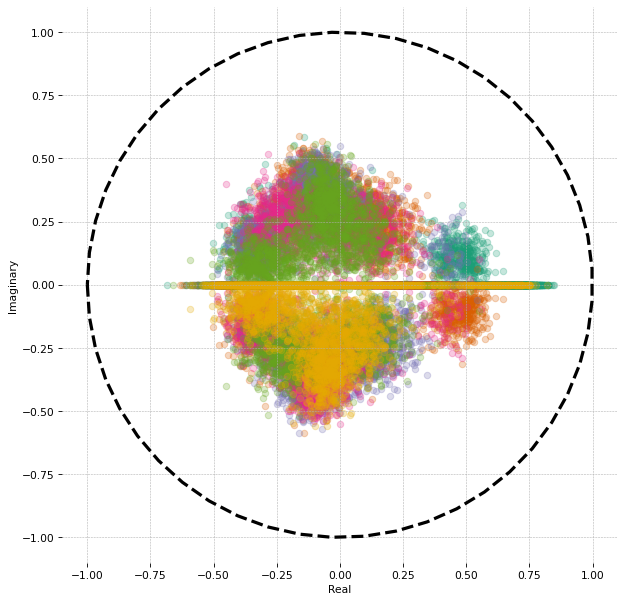

In [11]:
posterior_T = ss_mod.sample_statespace_matrices(idata.posterior, matrix_names=['T'])
plot_eigenvalues(posterior_T.posterior_predictive);

We can also check the prior samples of `x0` and `P0` against the posterior. As promised, they are unchanged. I point this out the emphasize that these are essentially nusiance parameters that we would like to be rid of.

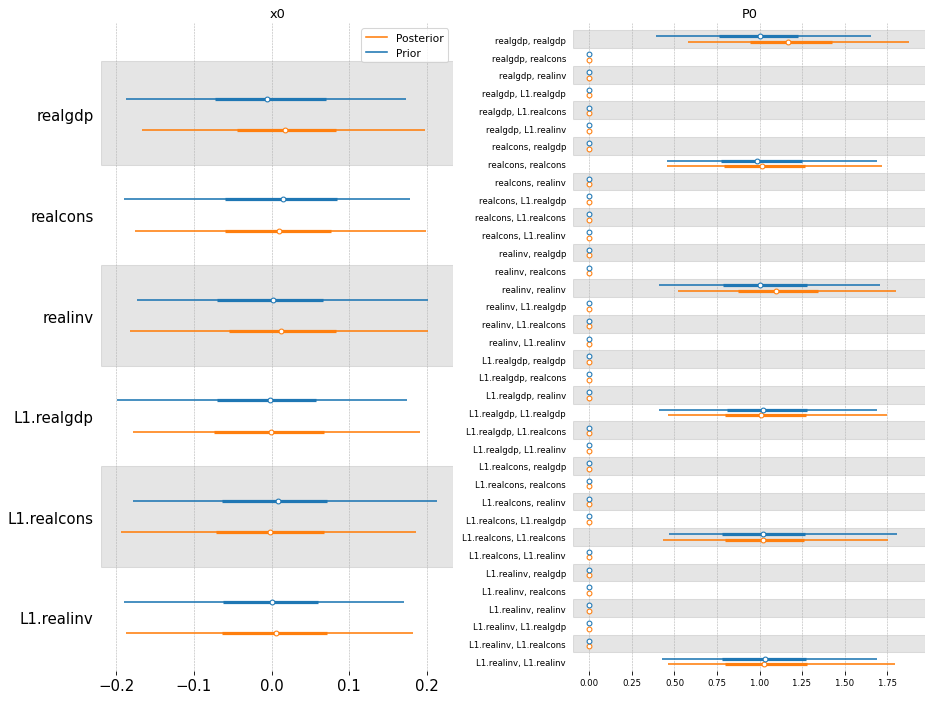

In [12]:
import re
fig, ax = plt.subplots(1, 2, figsize=(12, 9), dpi=77)
az.plot_forest([prior.prior, idata.posterior], 
               model_names=['Prior', 'Posterior'],
               var_names=['x0'],
               combined=True,
               ax=ax[0])
old_ticks = ax[0].yaxis.get_majorticklabels()
new_labels = [re.findall(r'(\[(.*?)\])', tick.get_text())[0][1] for tick in old_ticks]
ax[0].set(title='x0', yticklabels=new_labels)

az.plot_forest([prior.prior, idata.posterior], 
               model_names=['Prior', 'Posterior'],
               var_names=['P0'],
               combined=True,
               ax=ax[1],
               legend=True)
old_ticks = ax[1].yaxis.get_majorticklabels()
new_labels = [re.findall(r'(\[(.*?)\])', tick.get_text())[0][1] for tick in old_ticks]
ax[1].set(title='P0', yticklabels=new_labels)
ax[1].tick_params(labelsize=8)
ax[1].get_legend().remove()

plt.show()

## Post-Estimation

As before, we can sample the conditional posterior to look at the in-sample one-step ahead forecasts. The fact that we have multiple time series doesn't change anything -- all the post-estimation methods are the same. 

In [13]:
post_idata = ss_mod.sample_conditional_posterior(idata)

Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

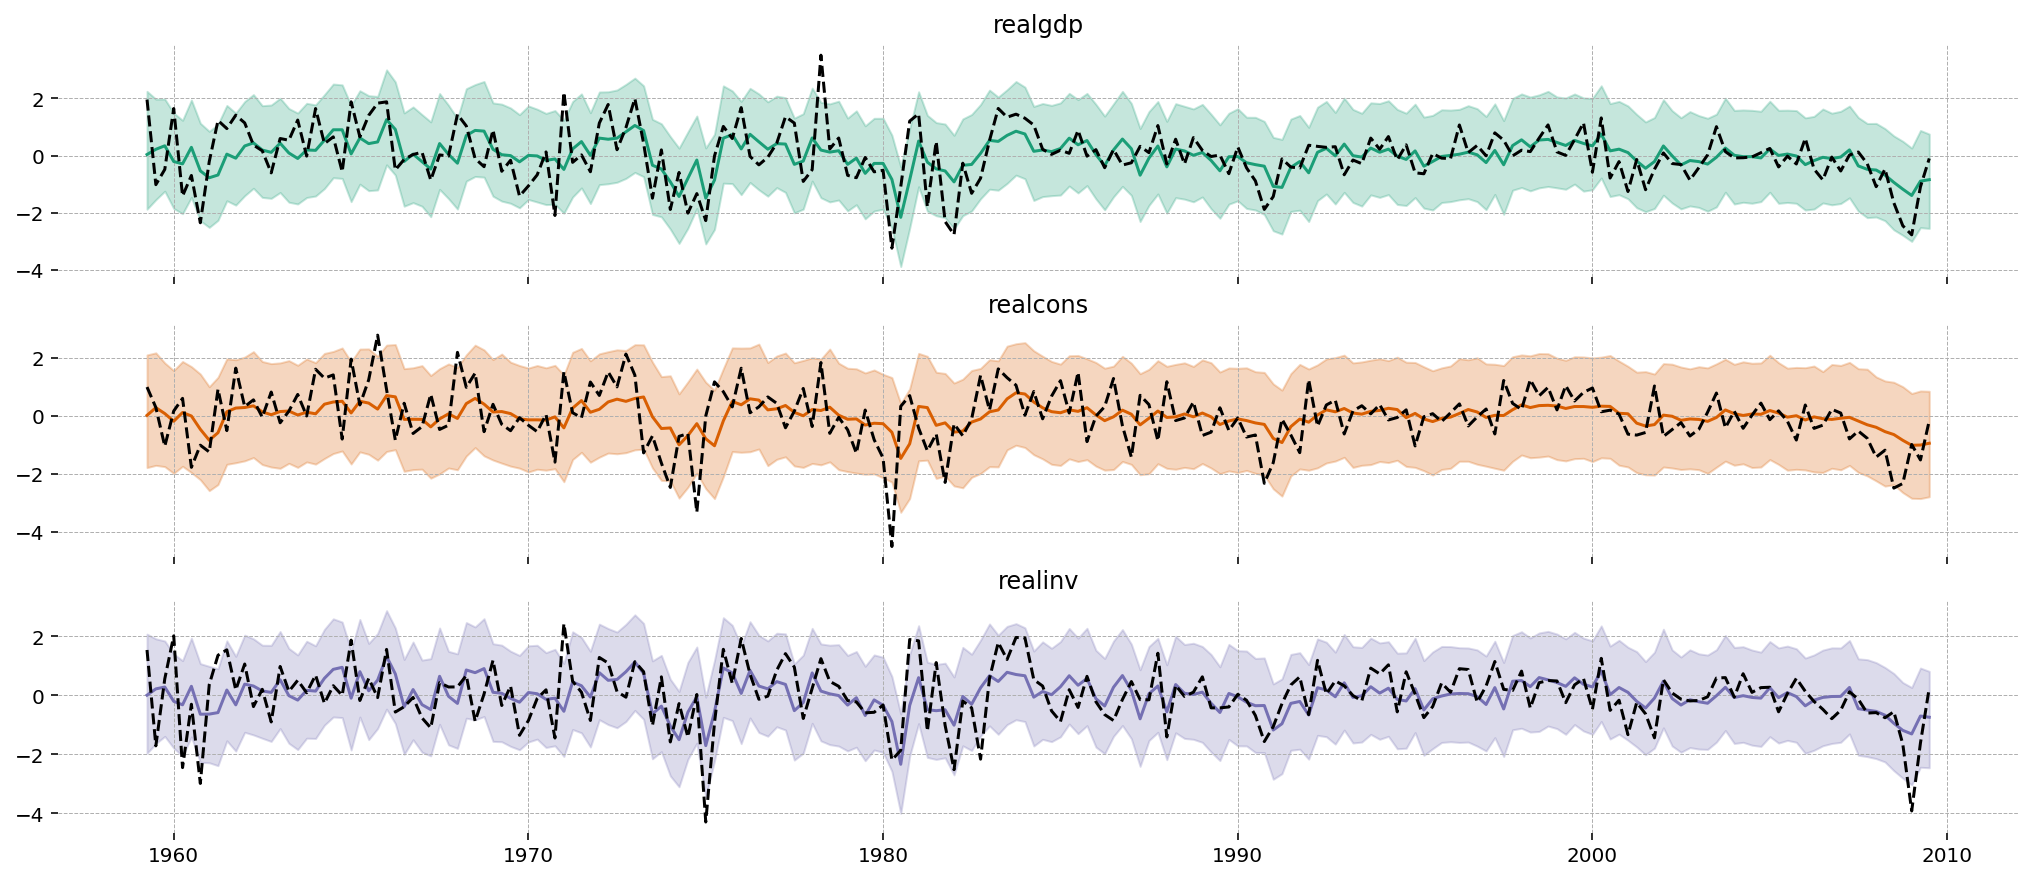

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(14, 6), sharex=True)
for i, (axis, name) in enumerate(zip(fig.axes, data)):
    plot_timeseries_posterior(post_idata.predicted_posterior_observed.sel(observed_state=name),
                              data=data[name],
                              ax=axis,
                              color=colors[i])
    axis.set_title(name)

In [15]:
forecast_idata = ss_mod.forecast(idata, periods=4 * 5)

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
Sampling: [forecast_combined]


Output()

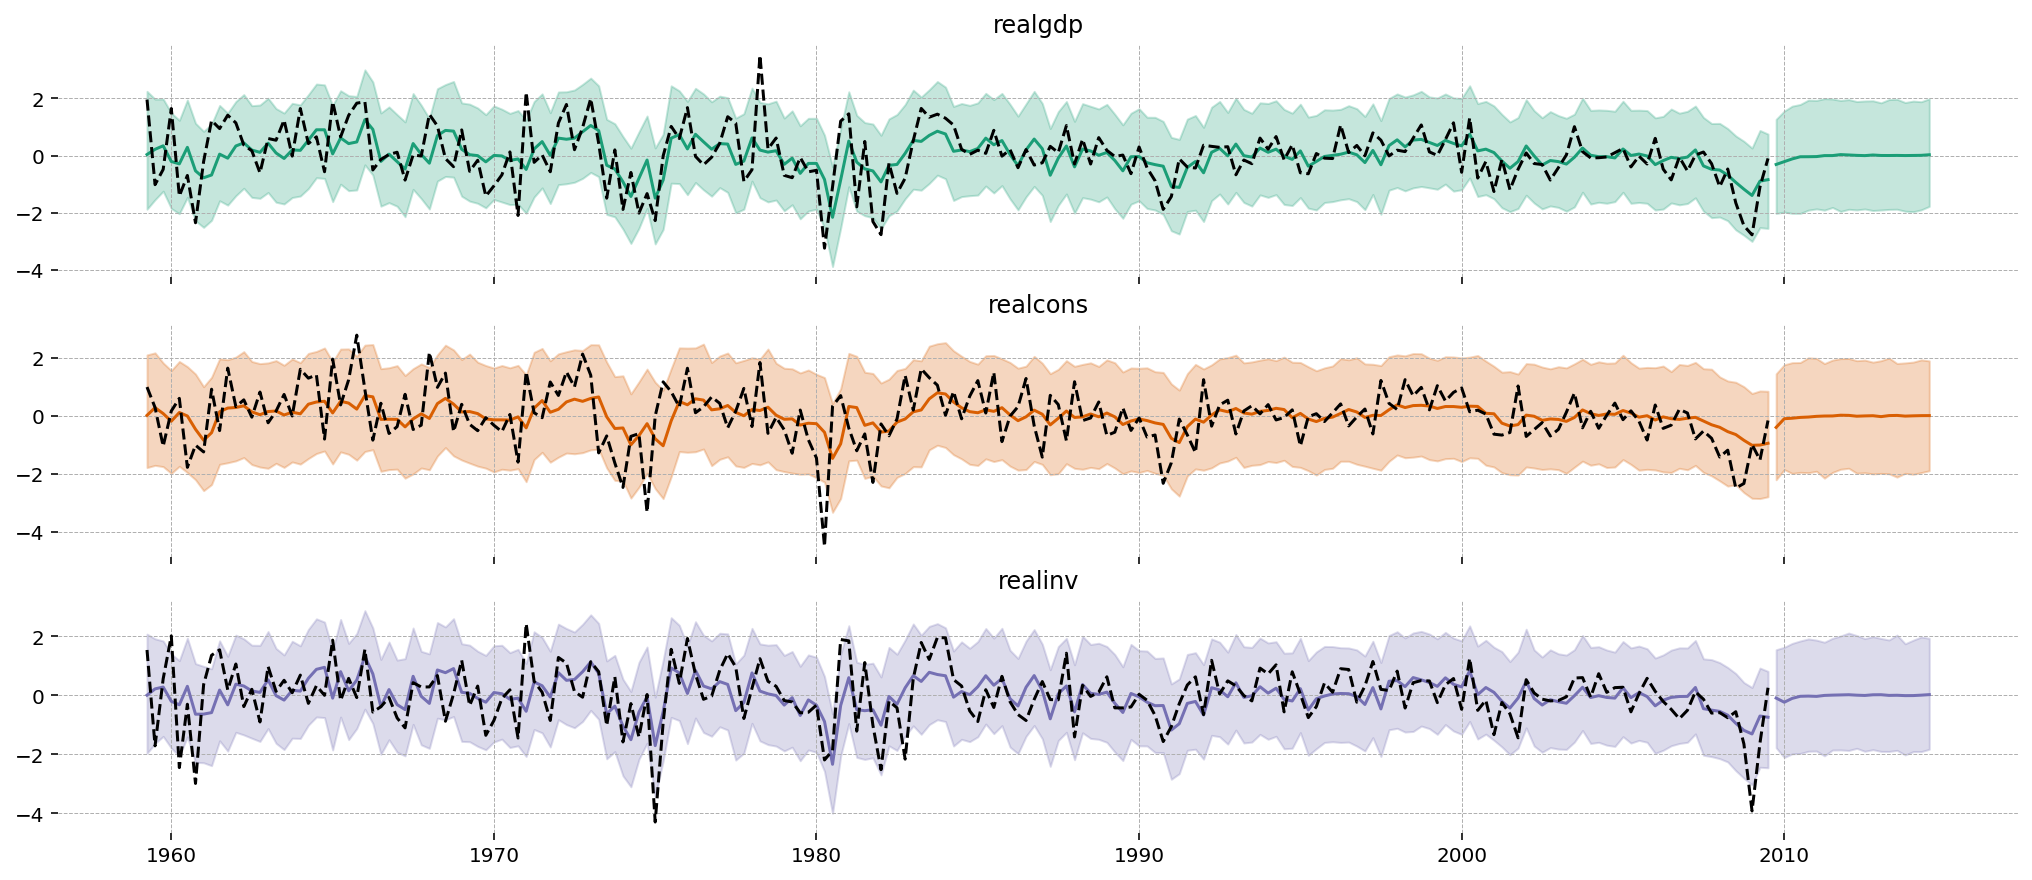

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(14, 6), sharex=True)
for i, (axis, name) in enumerate(zip(fig.axes, data)):
    axis = plot_timeseries_posterior(post_idata.predicted_posterior_observed.sel(observed_state=name),
                              data=data[name],
                              ax=axis,
                              color=colors[i])
    axis = plot_timeseries_posterior(forecast_idata.forecast_observed.sel(observed_state=name),
                                     color=colors[i], ax=axis)
    axis.set_title(name)

# Impulse Response Functons

One task that is interesting for a model of multiple variables (and multiple shocks) are impulse response functions. These show how the system evolves following a single, sudden impulse to one or more of the model shocks.

All statespace models include the `impulse_response_function` method for this purpose. To use it, you first need to provide a posterior. From there, there are several options

## Option 1: Sample shocks from Q

If you just provide `n_steps` (the number of steps for which to simulate the system after the shock), a shock will be applied at $t=0$. The shock will be sample from the posterior shock distribution, $\varepsilon_t \sim N(0, Q)$. 

This is perhaps the least interesting case.

In [17]:
irf_1 = ss_mod.impulse_response_function(idata, n_steps=10)

Sampling: [initial_shock]


Output()

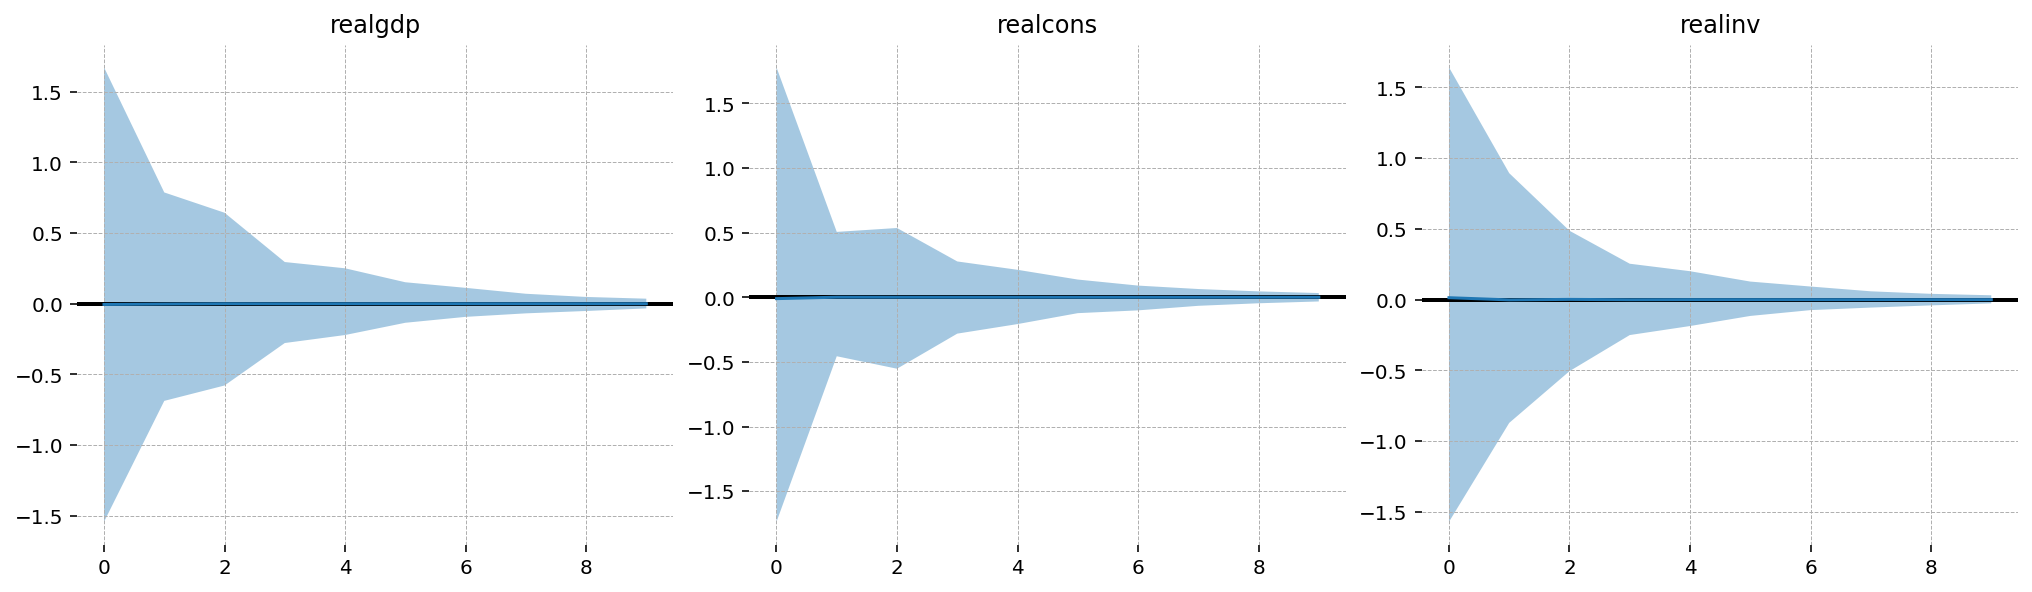

In [34]:
def plot_irf(idata, ss_mod, fig=None):
    states = ss_mod.observed_states
    
    if fig is None:
        fig, ax = plt.subplots(1, ss_mod.k_endog)
    
    irf_mu = idata.irf.mean(dim=['chain', 'draw'])
    irf_hdi = az.hdi(idata.irf).irf
    time_grid = idata.coords['time'].values
    for state, axis in zip(states, fig.axes):
        axis.axhline(0, lw=2, c='k')
        axis.plot(time_grid, irf_mu.sel(state=state))
        axis.fill_between(time_grid, *irf_hdi.sel(state=state).values.T, alpha=0.4)
        axis.set(title=state)
    return fig
    
plot_irf(irf_1, ss_mod);

## Option 2: Rotate Q

Instead of using $Q$ directly, you can do a factor rotation and use $Q^\star$ such that $Q = Q^\star (Q^\star)^T$. $Q^\star$ is lower-triangular (it comes from the cholesky decomposition), and is usually given a causal interpretation. In this case, the **order of the states matters**.

The interpretation is that temporally, a shock hits the first variable, then the second variable, as so on. In each step, we observe two things:

1. The effect of the i-th shock hitting the i-th variable, plus
2. The reverberations of the (i-1)th shock passing into the i-th variable.

Of course there is no effect (2) for the first variable. Thus the order matter. You need to reason about the causal structure of the VAR.

In [19]:
irf_2 = ss_mod.impulse_response_function(idata, n_steps=10, orthogonalize_shocks=True)

Sampling: [initial_shock]


Output()

In this case, the orthogalization only makes a small difference, and it mostly appears to be due to the scaling. I say this because the shape of the IRFs (orange vs blue) remains roughly the same, but the orange IRF is larger in all cases.

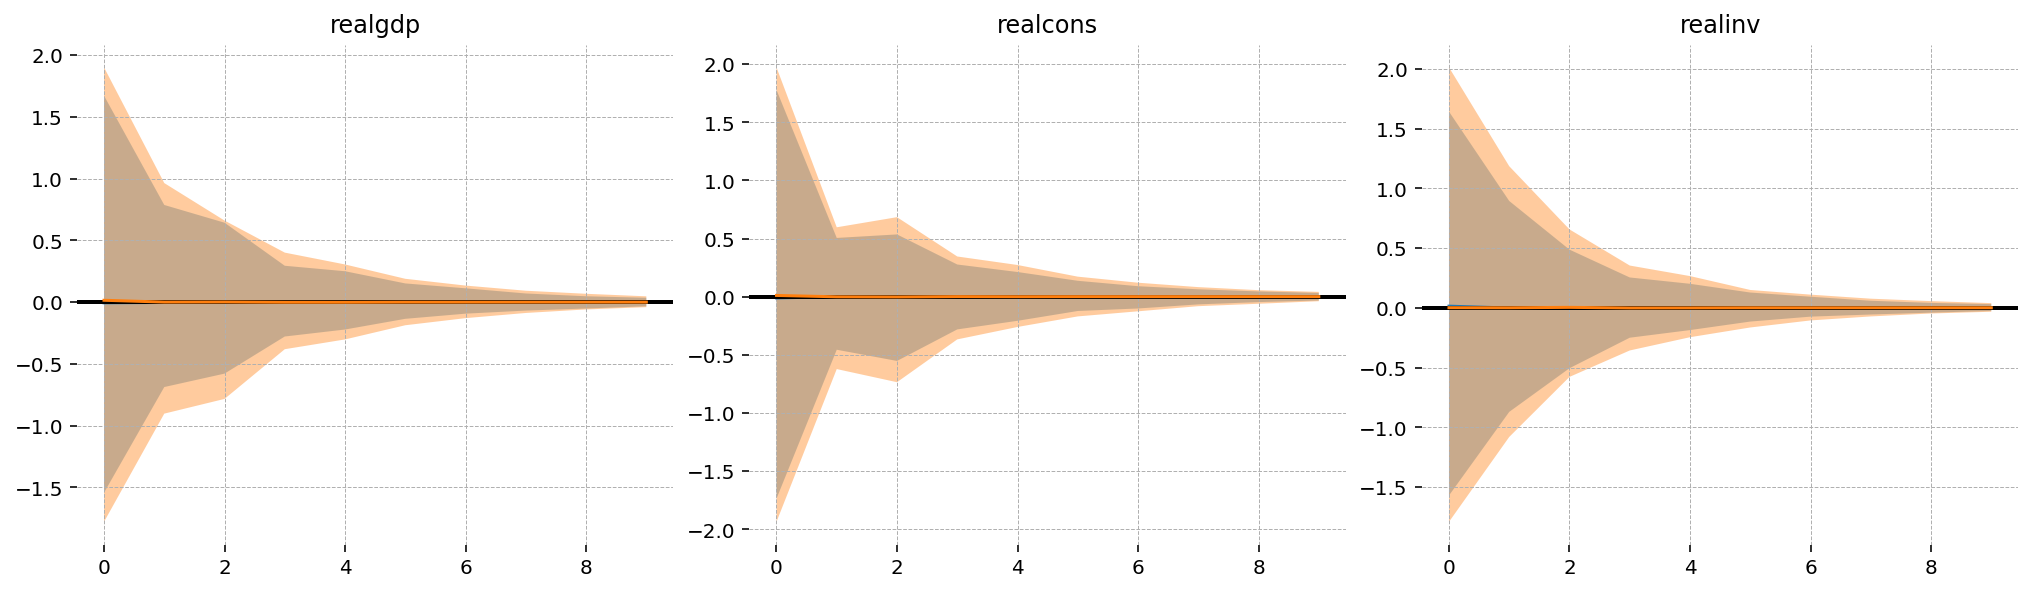

In [35]:
fig = plot_irf(irf_1, ss_mod)
plot_irf(irf_2, ss_mod, fig=fig);

## Option 3: Bring your own covariance

You can also provide your own covariance matrix. To do this, make a numpy matrix and pass it using the `shock_cov` argument.

Sampling: [initial_shock]


Output()

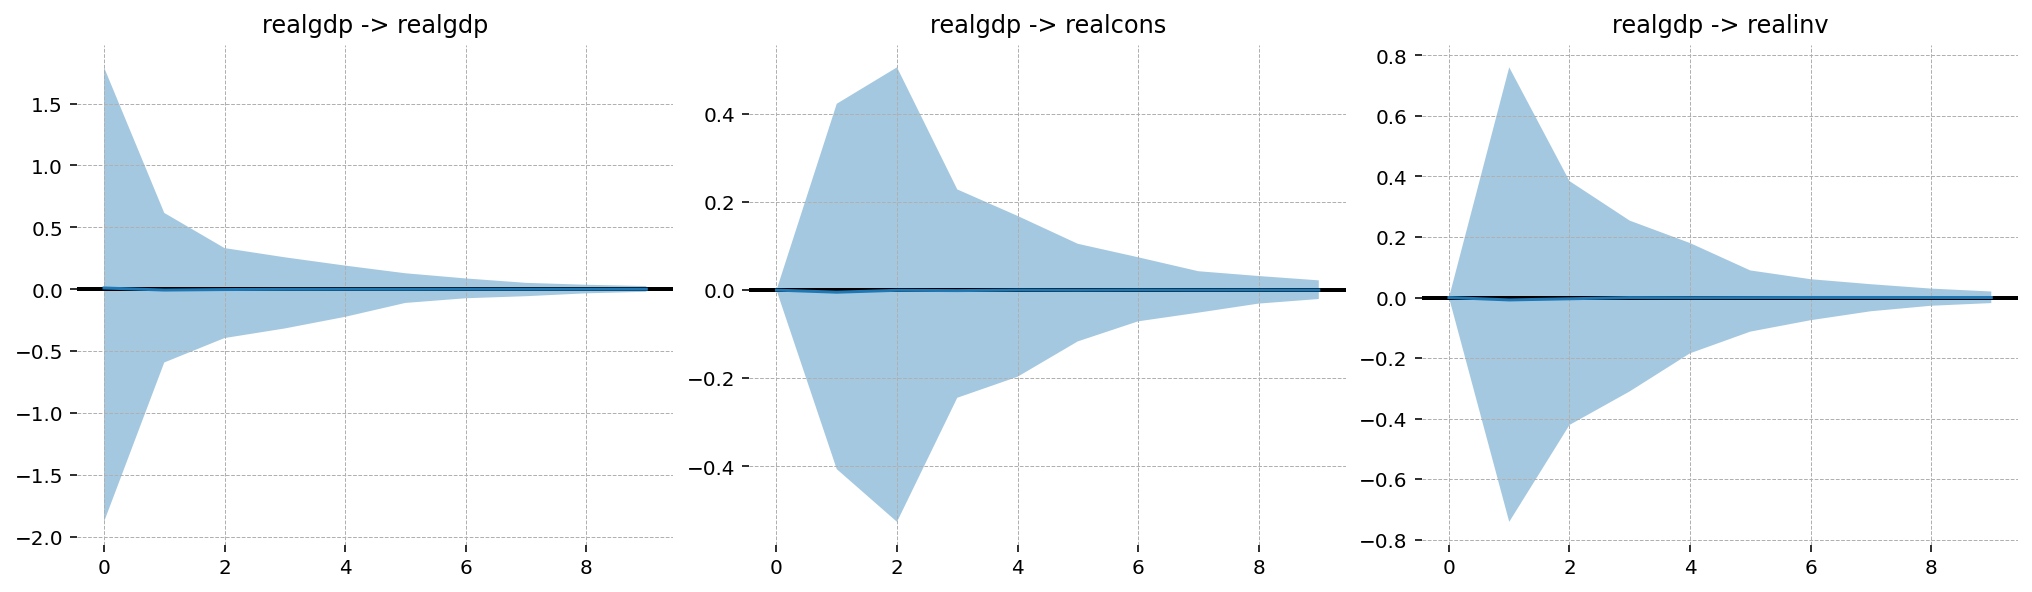

Sampling: [initial_shock]


Output()

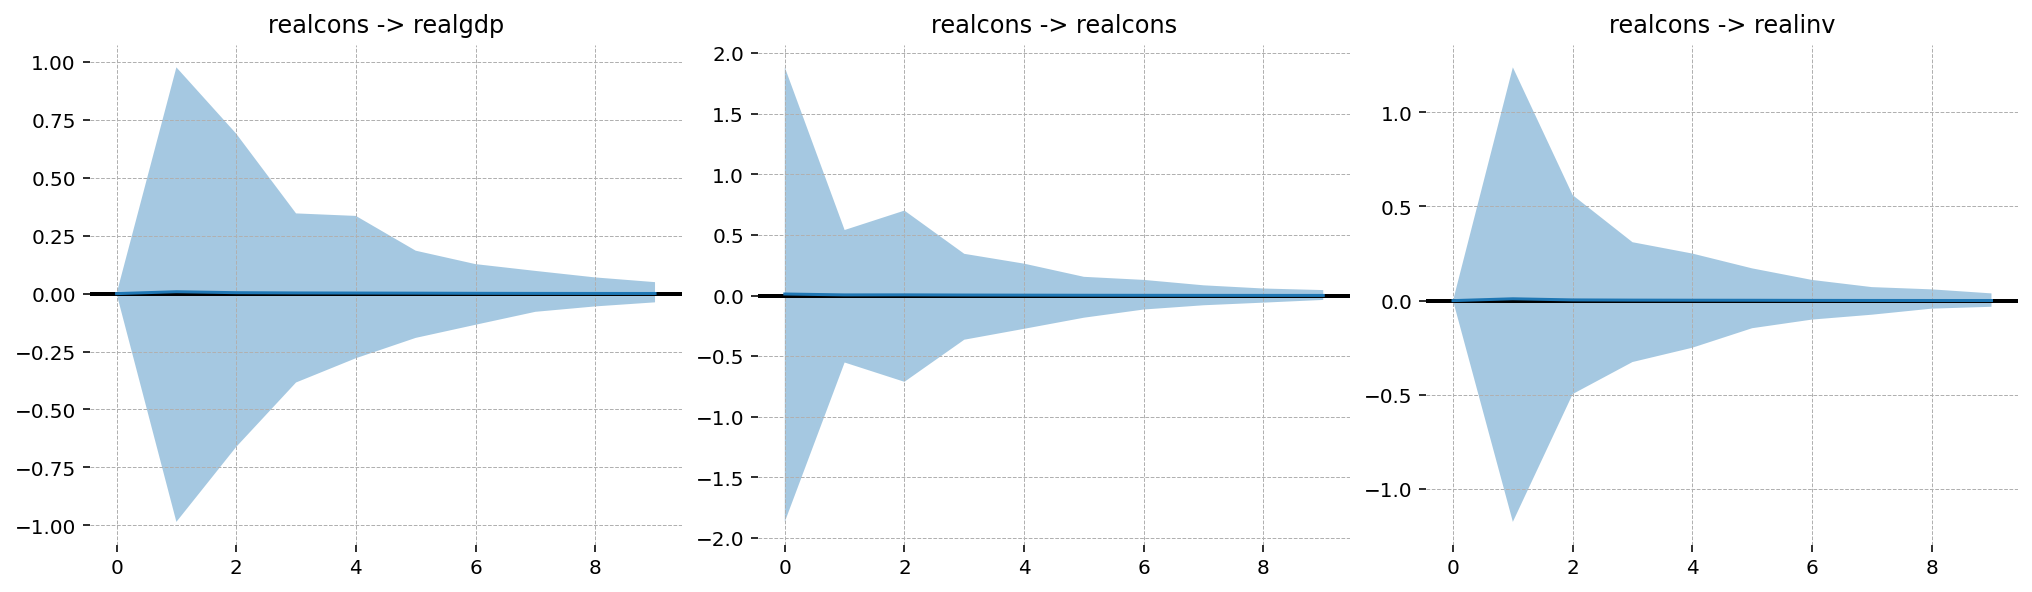

Sampling: [initial_shock]


Output()

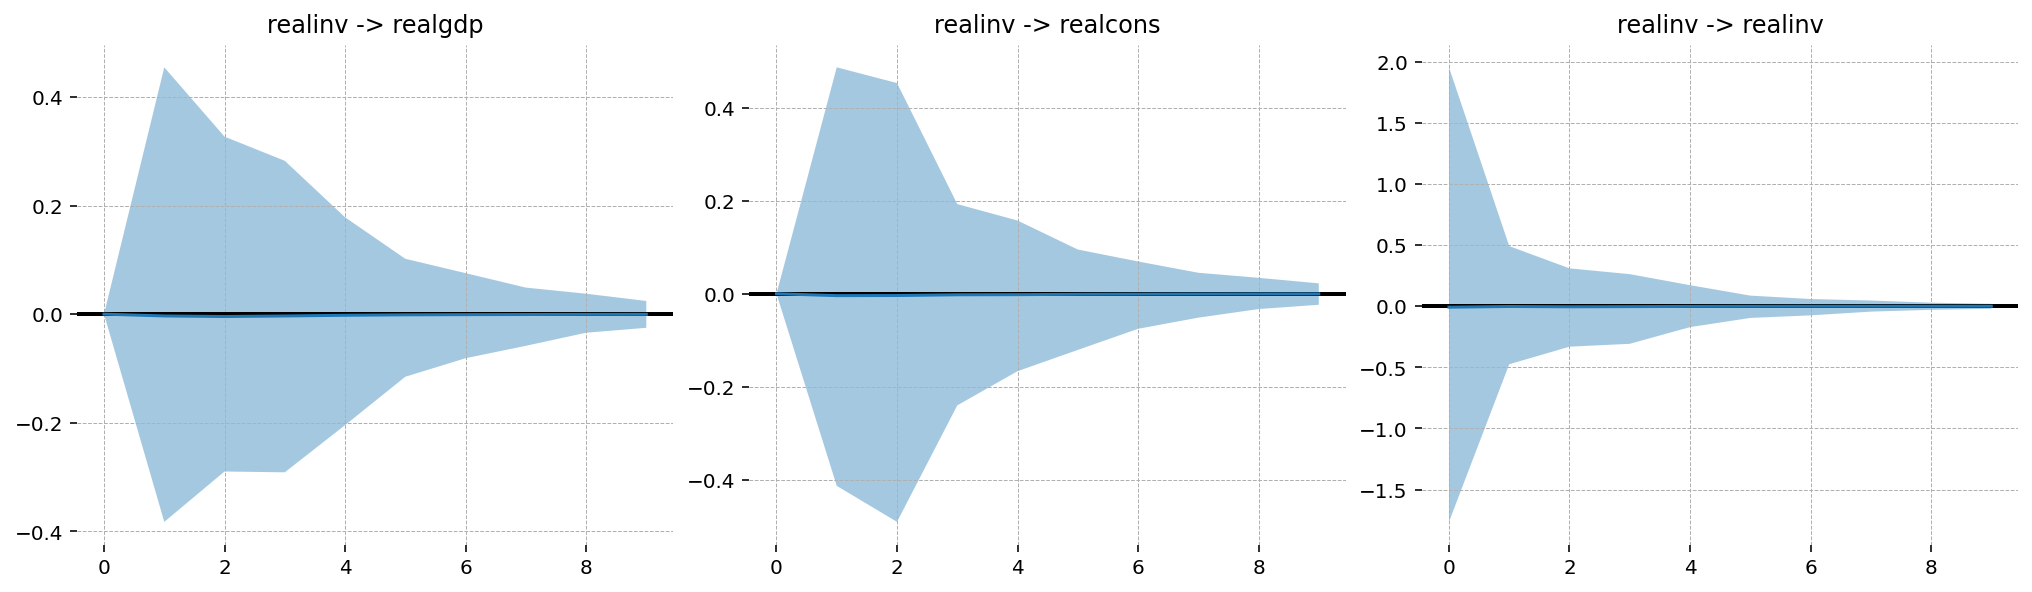

In [36]:
for i, state in enumerate(ss_mod.observed_states):
    shock_cov = np.zeros((3, 3))
    shock_cov[i, i] = 1

    irf_3 = ss_mod.impulse_response_function(idata, n_steps=10, shock_cov=shock_cov)
    fig = plot_irf(irf_3, ss_mod)
    for axis in fig.axes:
        title = axis.get_title()
        axis.set_title(f'{state} -> {title}')
    plt.show()

# Option 4: Directly define the shock sizes

Instead of working with a covariance matrix, you can directly ask for shock sizes by a numpy array with one entry per shock. The order of the shocks in the array is the order of the names in `ss_mod.shocks`.

Here the graphs will change, because we're no longer sampling the shocks before plotting the IRF. We're deterministically using the provided shock values. The HDI will reflect parameter uncertainty only.

This option is probably what you most expect as an IRF output, which most closely matches what STATA/statsmodels gives you

Sampling: []


Output()

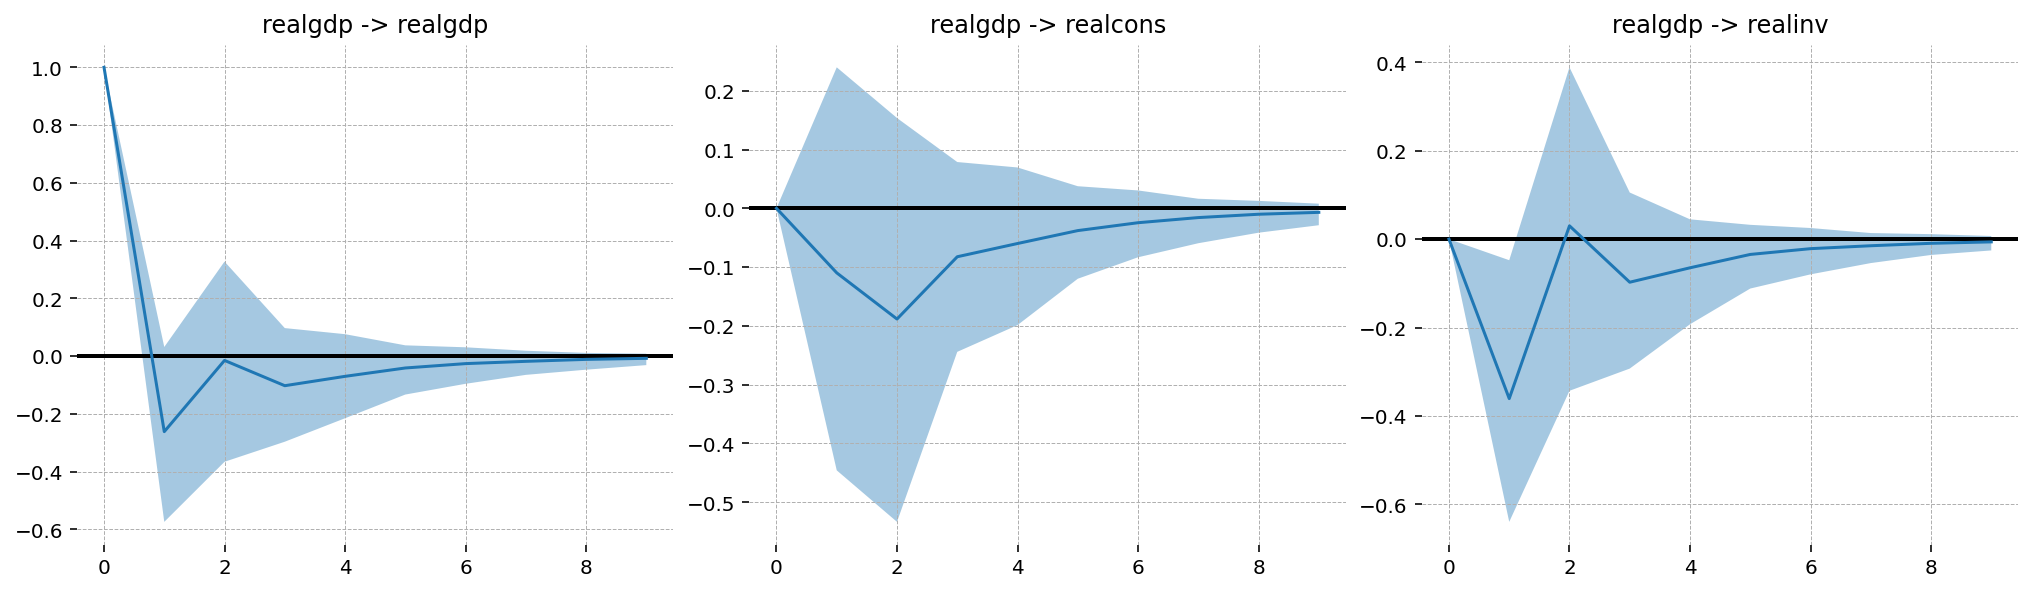

Sampling: []


Output()

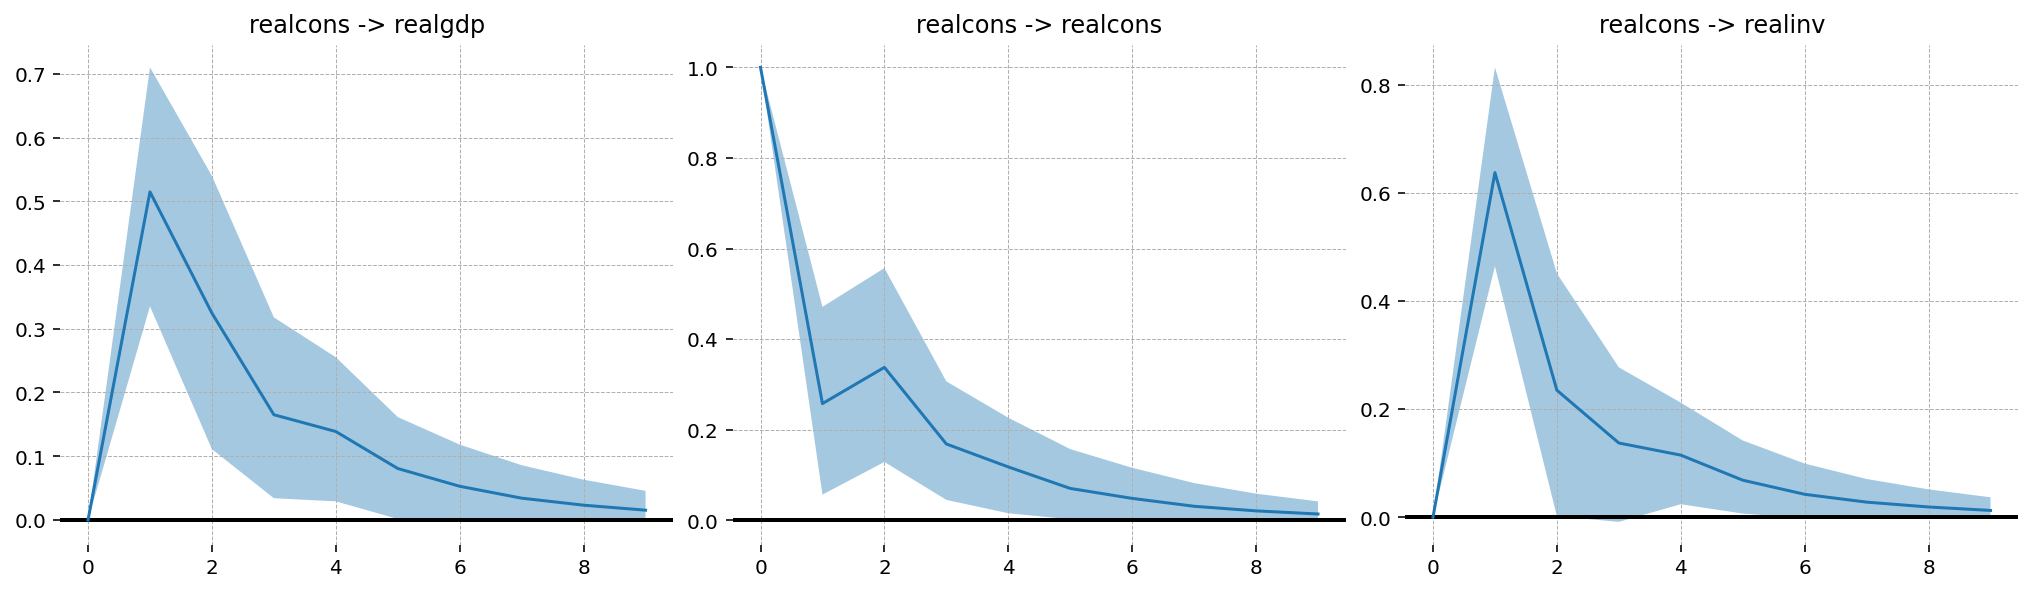

Sampling: []


Output()

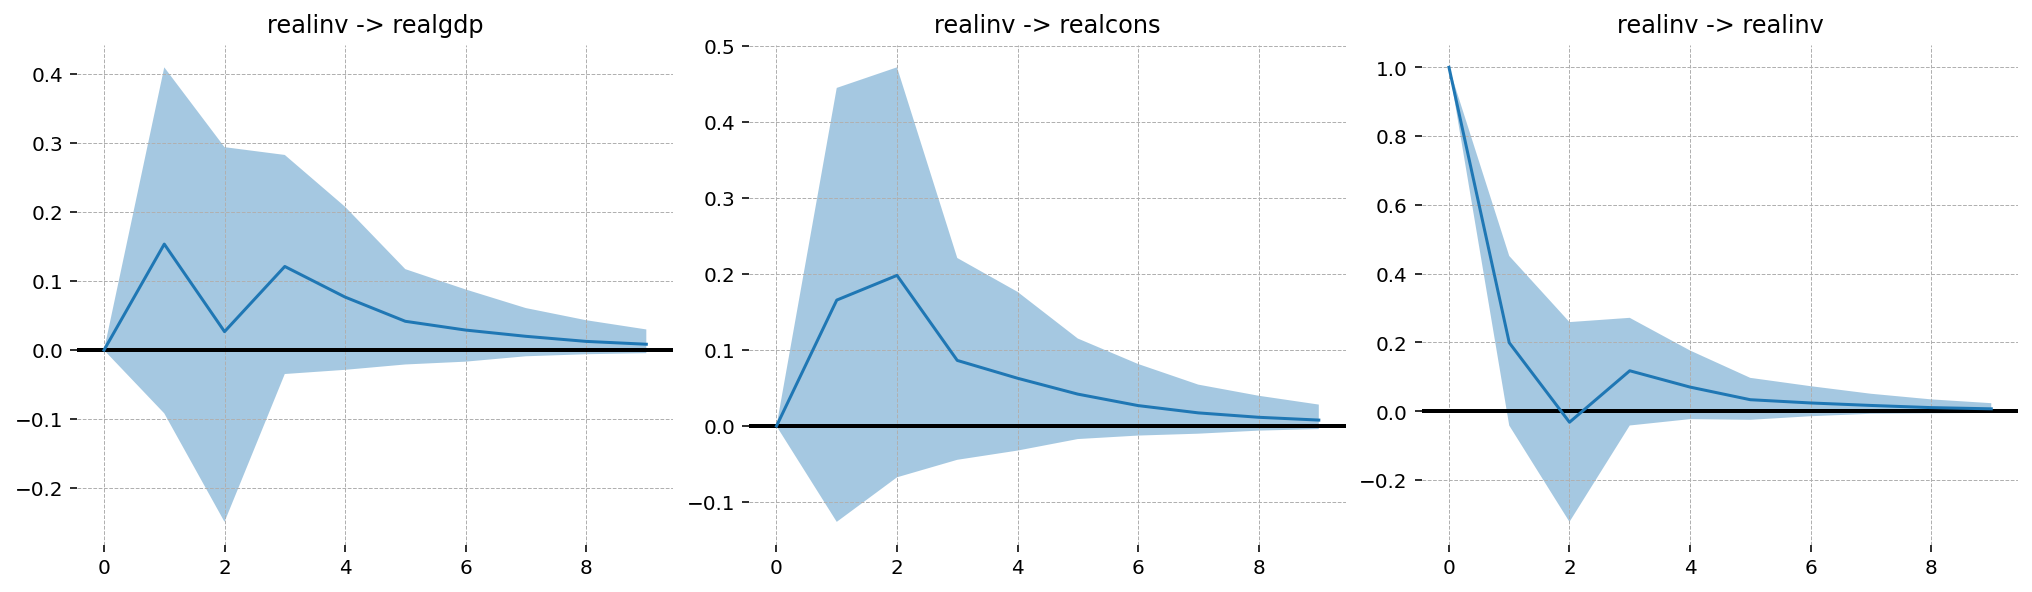

In [37]:
for i, state in enumerate(ss_mod.observed_states):
    shock_size = np.zeros(3)
    shock_size[i] = 1
    irf_4 = ss_mod.impulse_response_function(idata, n_steps=10, shock_size=shock_size)
    fig = plot_irf(irf_4, ss_mod)
    for axis in fig.axes:
        title = axis.get_title()
        axis.set_title(f'{state} -> {title}')
    plt.show()

## Option 5: Define an entire shock trajectory

For the real control freaks out there, you can define an entire trajectory over which to compute an IRF. This is useful for doing simulations. 

The expected shape is `(n_steps, n_shocks)`.

For example, we can consider a situation in which there is a GDP shock in period 0, followed by a consumption shock in period 3.

Sampling: []


Output()

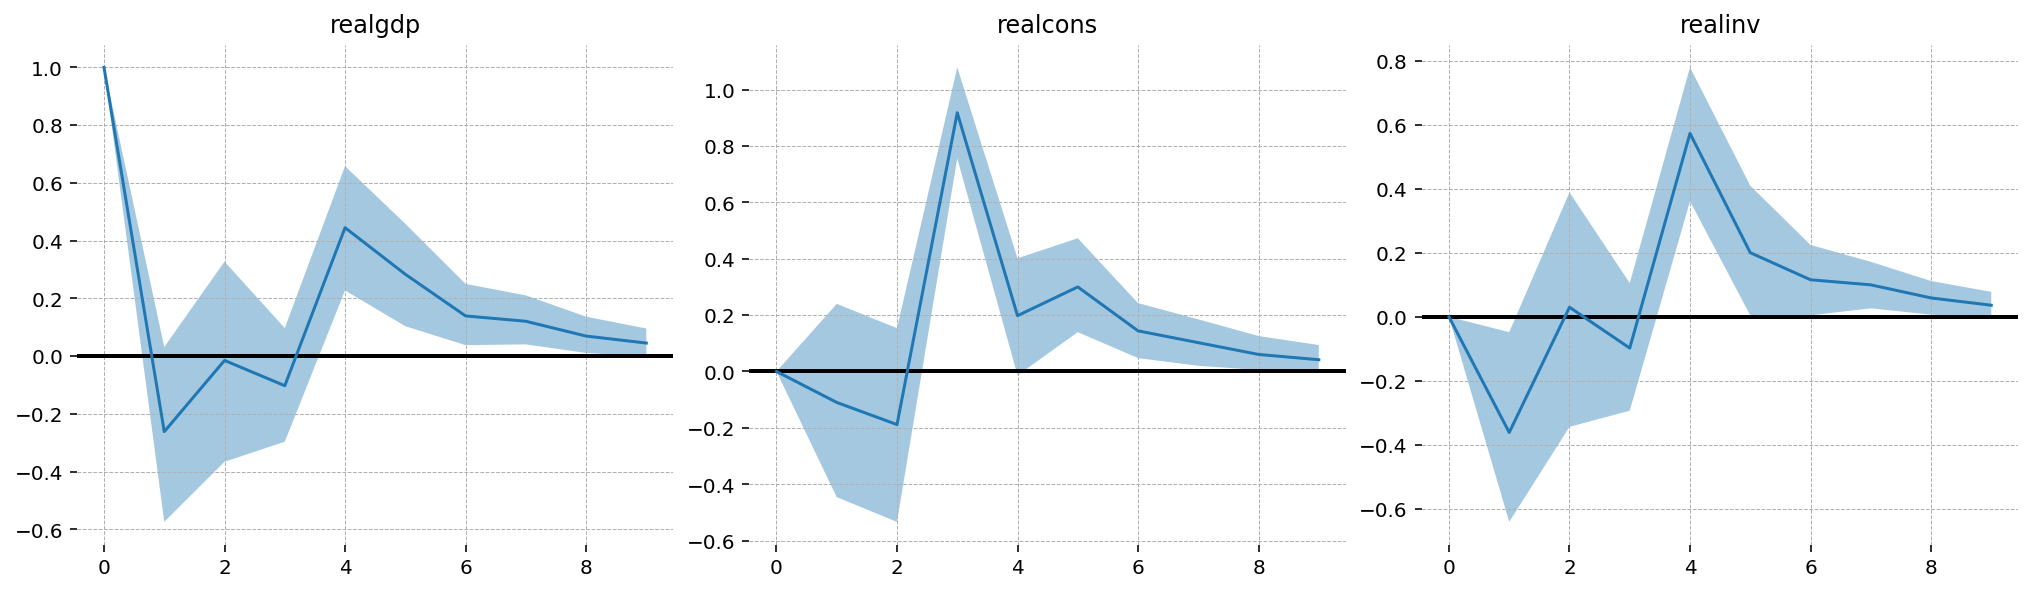

In [38]:
shock_trajectory = np.zeros((10, 3))
shock_trajectory[0, 0] = 1.0
shock_trajectory[3, 1] = 1.0

irf_5 = ss_mod.impulse_response_function(idata, shock_trajectory=shock_trajectory)
plot_irf(irf_5, ss_mod);

Admittedly, these scenarios don't make a lot of sense in this setting. But we can imagine a model with more interpretable states where such a scenario would be meaningful.